## Hyperparameter tuning with Optuna

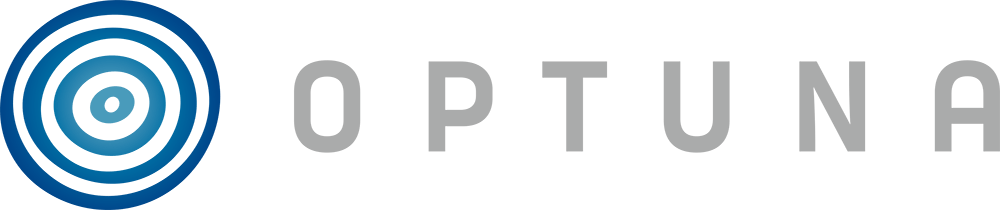

In [ ]:
!apt-get install -y xvfb

!pip install \
    gym==0.21 \
    gym[box2d] \
    pytorch-lightning==1.6.0 \
    optuna==2.7.0 \
    pyvirtualdisplay

#### Setup virtual display

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [ ]:
import copy
import statistics
import gym
import torch
import optuna

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics

from optuna.integration import PyTorchLightningPruningCallback

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [ ]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the Deep Q-Network

In [ ]:
class DQN(nn.Module):
    def __init__(self, hidden_size, obs_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),           
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        return self.net(x.float())

#### Create the policy

In [ ]:
def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
      action = env.action_space.sample()
  else:
      state = torch.tensor([state]).to(device)
      q_values = net(state)
      _, action = torch.max(q_values, dim=1)
      action = int(action.item())
  return action

#### Create the replay buffer

In [ ]:
Experience = namedtuple(
    "Experience",
    field_names=["state", "action", "reward", "done", "new_state"],
)

In [ ]:
class ReplayBuffer:

    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):

        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*(self.buffer[idx] for idx in indices))

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool),
            np.array(next_states),
        )

In [ ]:
class RLDataset(IterableDataset):

    def __init__(self, buffer, sample_size=200):
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self):
        states, actions, rewards, dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i]

#### Create the environment

In [ ]:
def create_environment(name):
  env = gym.make(name)
  env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda x: x % 50 == 0)
  env = RecordEpisodeStatistics(env)
  return env

#### Create the test/sampling function

In [ ]:
  @torch.no_grad()
  def play_episode(env, q_net, buffer, policy=None, epsilon=0.):
      obs = env.reset()
      done = False

      while not done:
        if policy:
          action = policy(obs, env, q_net, epsilon=epsilon)
        else:
          action = env.action_space.sample()
          
        next_obs, reward, done, info = env.step(action)
        exp = Experience(obs, action, reward, done, next_obs)
        buffer.append(exp)
        obs = next_obs

#### Create the Deep Q-Learning algorithm

In [ ]:
class DeepQLearning(LightningModule):

  def __init__(self, env_name, policy=epsilon_greedy, sample_fn=play_episode, 
               capacity=100_000, batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, 
               loss_fn=F.smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15, 
               eps_last_episode=100, samples_per_epoch=10_000, sync_rate=10):

    super().__init__()
    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape[0]
    n_actions = self.env.action_space.n

    self.q_net = DQN(hidden_size, obs_size, n_actions).to(device)
    self.target_q_net = copy.deepcopy(self.q_net)
    self.policy = policy

    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch:

      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.hparams.sample_fn(self.env, self.q_net, self.buffer, epsilon=self.hparams.eps_start)
  
  def forward(self, x):
    output = self.q_net(x)
    return output

  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), lr=self.hparams.lr)
    return [q_net_optimizer]

  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size,
    )
    return dataloader

  def training_step(self, batch, batch_idx):

    states, actions, rewards, dones, next_states = batch
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)
    state_action_values = self.q_net(states).gather(1, actions)

    with torch.no_grad():
      next_state_values, _ = self.target_q_net(next_states).max(dim=1, keepdim=True)
      next_state_values[dones] = 0.0
    
    expected_state_action_values = rewards + self.hparams.gamma * next_state_values

    loss = self.hparams.loss_fn(state_action_values, expected_state_action_values)
    self.log('episode/MSE Loss', loss, on_step=False, on_epoch=True)
    return loss


  def training_epoch_end(self, training_step_outputs):

    epsilon = max(
        self.hparams.eps_end,
        self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
    )

    self.hparams.sample_fn(self.env, self.q_net, self.buffer, policy=self.policy, epsilon=epsilon)

    self.log("episode/Return", self.env.return_queue[-1])
    if self.current_epoch == 199:
      returns = list(self.env.return_queue)
      self.log("hp_metric", statistics.mean(returns))
    

    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

#### Create the objective function

In [ ]:
def objective(trial):
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  gamma = trial.suggest_float("gamma", 0.0, 1.0)
  hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
  eps_end = trial.suggest_float("eps_end", 0.0, 0.3)

  algo = DeepQLearning(
      'LunarLander-v2',
      lr=lr,
      gamma=gamma,
      hidden_size=hidden_size,
      eps_end=eps_end
  )

  callback = PyTorchLightningPruningCallback(trial, monitor="episode/Return")

  trainer = Trainer(
      gpus=num_gpus, 
      max_epochs=200,
      track_grad_norm=2,
      callbacks=[callback]
  )

  hyperparameters = dict(
      lr=lr, 
      gamma=gamma, 
      hidden_size=hidden_size,
      eps_end=eps_end
  )
  
  trainer.logger.log_hyperparams(hyperparameters)
  trainer.fit(algo)

  return trainer.callback_metrics["episode/Return"].item()

#### Create the optimization study

In [ ]:
pruner = optuna.pruners.SuccessiveHalvingPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)

#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
# Start tensorboard.
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Run the hyperparameter search

In [ ]:
study.optimize(objective, n_trials=20)

#### Select and use the best hyperparameters

In [ ]:
study.best_params

In [ ]:
# Start tensorboard.
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

In [ ]:
algo = DeepQLearning('LunarLander-v2', **study.best_params)

trainer = Trainer(
  gpus=num_gpus, 
  max_epochs=1000,
  track_grad_norm=2,
)

trainer.fit(algo)

#### Check the resulting policy

In [ ]:
display_video(episode=500)